## Consolidating our model runs

We have written a model to study whether our data is more likely to be drawn from the `standard` or `rocrit` models presented in van Saders et al. (2019).

We evaluate this using a mixture model, where:

\begin{equation}
p(\theta, P_{s} | D_i) = [P_s \text{KDE}_s(\theta) + (1-P_s)\text{KDE}_{Ro}(\theta)]p(D|\theta)p(P_{s})\, ,
\end{equation}

where $\theta$ are hyperparameters compared directly to measurements of our data in **mass, temperature, log age & log rotation**. $\rm KDE_s$ is a Kernel Density Estimate of the van Saders standard model, and $\rm \rm KDE_{Ro}$ is the same for the critical Rossby model.

If $P_s$ is close to or equal to zero, our set of asteroseismic age and rotation lies in favour of the conditions of the van Saders Rossby model being true, i.e. the weakened magnetic breaking theory.

The equation above functions only for a single star. We want the probability of one model or the other being true given our *entire* dataset, so we multiply all the posterior probabilities for each star together.

In practice, not all stars will inform this result: subgiants and cooler, less evolved stars will either be dominated by other angular momentum changes, or not yet experiencing the effect of weakened magnetic braking. We can study the effects different stellar groups have on the combined posterior estimate of $P_s$ by making the calculation using different stellar groups.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
from scipy.stats import gaussian_kde
sns.set_context('poster')
# sns.set_context('paper')
sns.set_palette('colorblind')

In [2]:
ati = pd.read_csv('../data/atium.csv', index_col=0)
ati = ati[ati.eye_flag != 3]
kics = ati.KIC.values
print(f'Working with {len(ati)} stars')

Working with 94 stars


Reading in the posterior samples

In [3]:
%%time
d = '/home/oliver/PhD/mnt/RDS/malatium/models_upgrade/'
post_pa = []
for idx, kic in enumerate(kics):
    try:
        post_pa.append(pd.read_csv(f"{d}{int(kic)}_samples.csv")['P_A'])
    except FileNotFoundError:
        print(f'File not found for index {idx}')
        ati.drop(index=idx, inplace=True)
        continue               

File not found for index 75
CPU times: user 19.8 s, sys: 3.13 s, total: 23 s
Wall time: 23.8 s


In an ideal world, we would multiply the posterior functions for every star. However we have samples instead of functions. We overcome this by multiplying the probability value in each of 100 bins for all stars, approximating the shape of a combined posterior function.

In [4]:
bins = np.linspace(0, 1, 101)
hists = np.array([np.histogram(n, bins=bins, density=True)[0] for n in post_pa])

### The overall result:

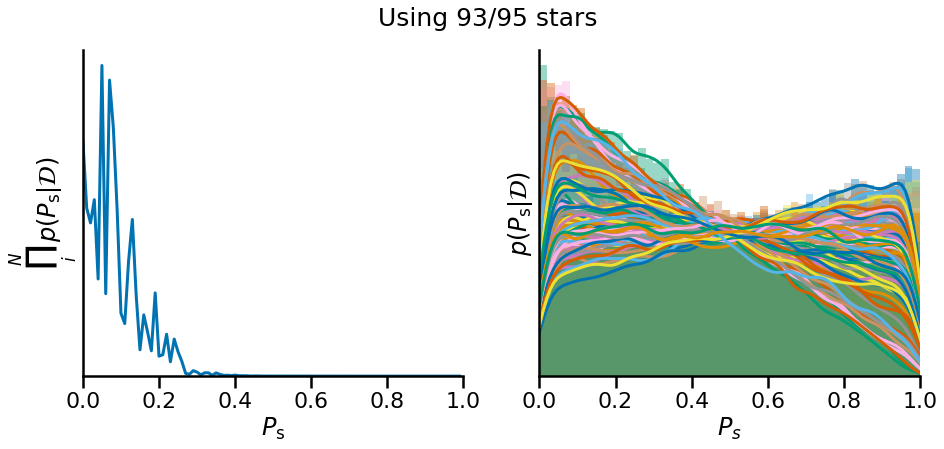

In [5]:
posterior = np.prod(hists, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(bins[:-1], posterior)
# ax[0].set_xlabel('Probability Jen is wrong')
ax[0].set_xlabel(r'$P_{\rm s}$')
ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s}} | \mathcal{D})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
for n in post_pa:
    sns.distplot(n, ax=ax[1])
ax[1].set_ylabel(r'$p(P_{\rm{s}} | \mathcal{D})$')
ax[1].set_xlabel(r'$P_s$')
ax[1].set_xlim(0, 1)
ax[1].get_yaxis().set_ticks([])
sns.despine()

fig.suptitle(fr'Using {len(post_pa)}/95 stars', fontsize=25)

plt.show()

### Comparing stellar type

In [6]:
print(ati.hrclass.unique())

['H' 'MS' 'SG']


Set up the classifications:

In [7]:
sg = ati['hrclass'] == 'SG'
ms = ati['hrclass'] == 'MS'
h = ati['hrclass'] == 'H'
print(f'We have {len(ati[sg])} Sub-Giant stars.')
print(f'We have {len(ati[h])} Hot stars.')
print(f'We have {len(ati[ms])} Main-Sequence stars.')

We have 4 Sub-Giant stars.
We have 24 Hot stars.
We have 65 Main-Sequence stars.


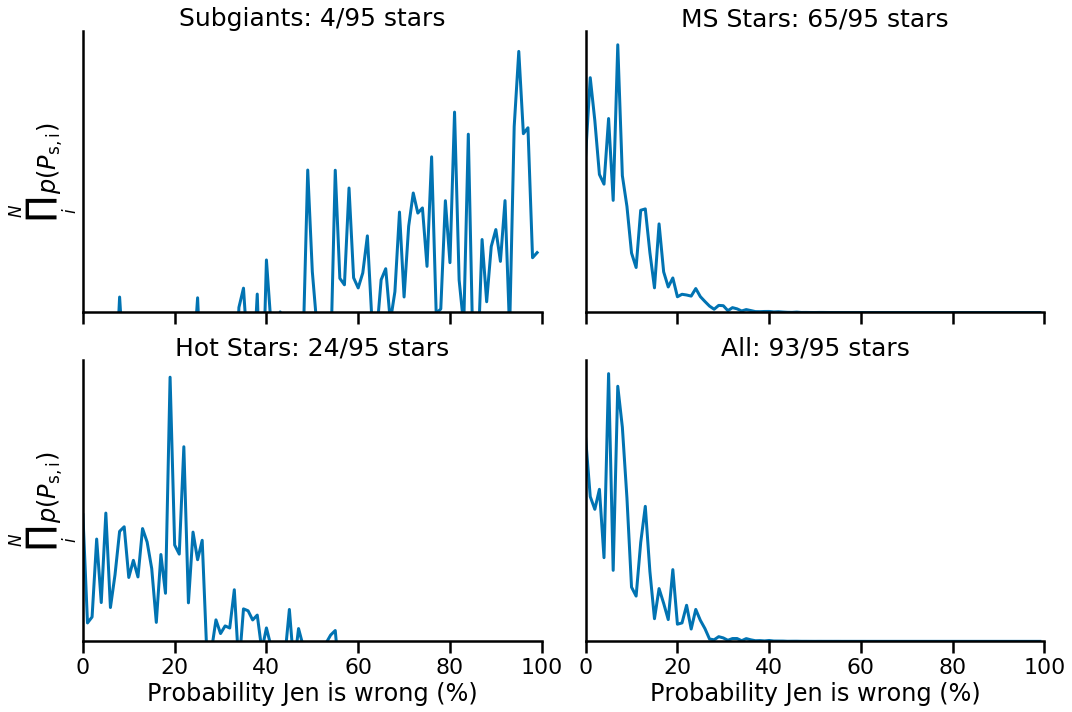

In [8]:
posterior = np.prod(hists, axis=0)

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(15,10))
ax = ax.flatten()
ax[0].plot(bins[:-1], np.prod(hists[sg], axis=0))
ax[0].set_title(fr'Subgiants: {len(hists[sg])}/95 stars', fontsize=25)
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(1)

ax[1].plot(bins[:-1], np.prod(hists[ms], axis=0))
ax[1].set_title(fr'MS Stars: {len(hists[ms])}/95 stars', fontsize=25)
ax[1].get_yaxis().set_ticks([])
ax[1].set_xlim(0, 1)
ax[1].set_ylim(1)

ax[2].plot(bins[:-1], np.prod(hists[h], axis=0))
ax[2].set_title(fr'Hot Stars: {len(hists[h])}/95 stars', fontsize=25)
ax[2].get_yaxis().set_ticks([])
ax[2].set_xlim(0, 1)
ax[2].set_ylim(1)

ax[3].plot(bins[:-1], np.prod(hists, axis=0))
ax[3].set_title(fr'All: {len(hists)}/95 stars', fontsize=25)
ax[3].get_yaxis().set_ticks([])
ax[3].set_xlim(0, 1)
ax[3].set_ylim(1)

ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s, i}})$')
ax[2].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s, i}})$')
ax[2].set_xlabel(r'Probability Jen is wrong (%)')
ax[3].set_xlabel(r'Probability Jen is wrong (%)')
ax[2].set_xticklabels(['0', '20','40','60','80','100'])

sns.despine()
fig.tight_layout()
plt.show()

Here I've plotted the combined posterior probabilities for stars in certain evolutionary groups.

- MS stars are strongly in favour of a critical Rossby number. This should be enough to satisfy anybody looking for a `smoking gun` in these rotation rates.
- Hot stars and Subgiant stars have relatively little to contribute.
- Its curious that hot stars seem to explicitly favour a **mixture** of the two models, which can likely be attributed to falling out of the active range of the KDE.

### A conservative check on KDE membership

Since Jen's 2019 models were intended only really to look at stars below the Kraft break, there may be some stars that were included in the posterior estimation, but weren't properly represented in Jen's models.

To mitigate this, I'll make a selection to remove any stars that weren't directly inside the parameter spaces of the two models.

In [9]:
stan = pd.read_hdf('../data/jvs_models/standard_population.h5', key='sample', mode='r')
ro = pd.read_hdf('../data/jvs_models/rocrit_population.h5', key='sample', mode='r')

In [10]:
cols = ['Teff','period','age','mass']
bound_s = [(stan[par].min(), stan[par].max()) for par in cols]
cols = ['Teff','period','age','mass']
bound_ro = [(ro[par].min(), ro[par].max()) for par in cols]

In [11]:
c1 = ati.copy(deep=True)
sel = []

cols = ['Teff', 'P', 'age', 'modmass']
for idx in c1.index:
    par = [c1.loc[idx][col] for col in cols]
    if not all(b[0] < v < b[1] for v, b in list(zip(par, bound_s))):
        c1.drop(index=idx, inplace=True)
        sel.append(False)
    elif not all(b[0] < v < b[1] for v, b in list(zip(par, bound_ro))):
        c1.drop(index=idx, inplace=True)
        sel.append(False)
    else:
        sel.append(True)
        pass

In [12]:
hists_sel = hists[sel]
sg = c1['hrclass'] == 'SG'
ms = c1['hrclass'] == 'MS'
h = c1['hrclass'] == 'H'
print(f'We have {len(c1[sg])} Sub-Giant stars.')
print(f'We have {len(c1[h])} Hot stars.')
print(f'We have {len(c1[ms])} Main-Sequence stars.')

We have 4 Sub-Giant stars.
We have 24 Hot stars.
We have 55 Main-Sequence stars.


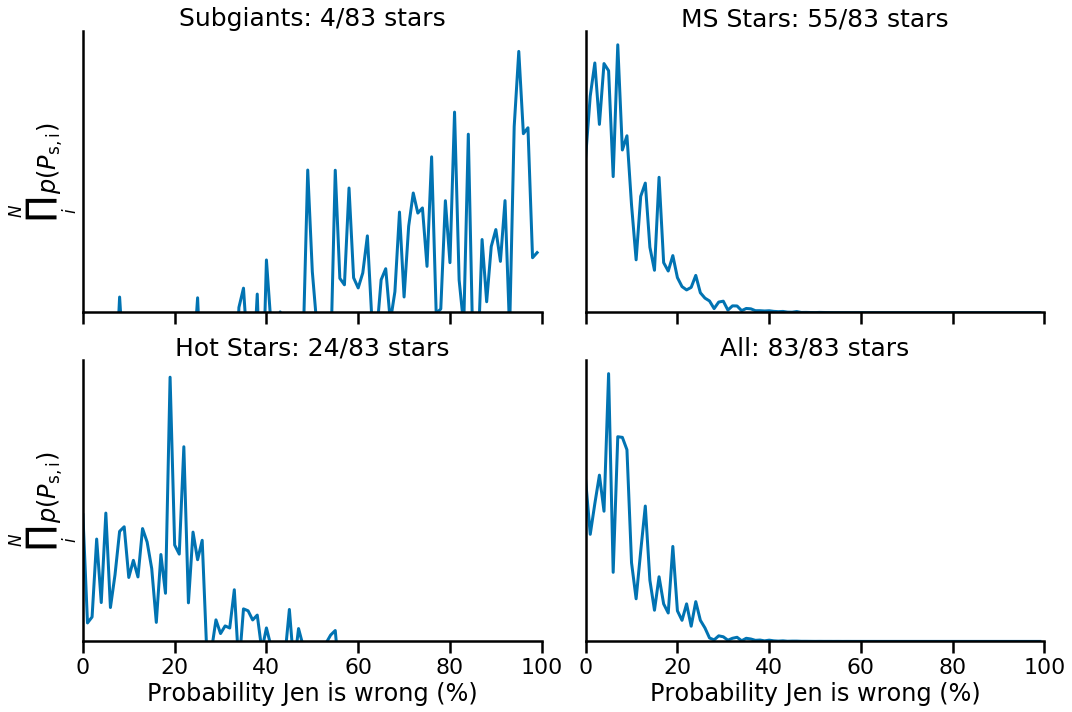

In [13]:
posterior = np.prod(hists, axis=0)

fig, ax = plt.subplots(2, 2, sharex=True,  figsize=(15,10))
ax = ax.flatten()
ax[0].plot(bins[:-1], np.prod(hists_sel[sg], axis=0))
ax[0].set_title(fr'Subgiants: {len(hists_sel[sg])}/{len(c1)} stars', fontsize=25)
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(1)

ax[1].plot(bins[:-1], np.prod(hists_sel[ms], axis=0))
ax[1].set_title(fr'MS Stars: {len(hists_sel[ms])}/{len(c1)} stars', fontsize=25)
ax[1].get_yaxis().set_ticks([])
ax[1].set_xlim(0, 1)
ax[1].set_ylim(1)

ax[2].plot(bins[:-1], np.prod(hists_sel[h], axis=0))
ax[2].set_title(fr'Hot Stars: {len(hists_sel[h])}/{len(c1)} stars', fontsize=25)
ax[2].get_yaxis().set_ticks([])
ax[2].set_xlim(0, 1)
ax[2].set_ylim(1)

ax[3].plot(bins[:-1], np.prod(hists_sel, axis=0))
ax[3].set_title(fr'All: {len(hists_sel)}/{len(c1)} stars', fontsize=25)
ax[3].get_yaxis().set_ticks([])
ax[3].set_xlim(0, 1)
ax[3].set_ylim(1)

ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s, i}})$')
ax[2].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s, i}})$')
ax[2].set_xlabel(r'Probability Jen is wrong (%)')
ax[3].set_xlabel(r'Probability Jen is wrong (%)')
ax[2].set_xticklabels(['0', '20','40','60','80','100'])

sns.despine()
fig.tight_layout()
plt.show()

When removing outlier stars, the result is still maintained. With MS stars only, magnetic braking is still the most probably outcome, fortunately.

Some things to note:
- Now we're only include Hot stars in the KDE range, we see that they mostly agree with magnetic braking. Could this be interpreted as the Kraft Break lying at higher temperatures, or is it a coincidence?
- Can we increase the scope of the models to include later ages?
- Can we ensure both models capture the same temperature range?

### A check on convergence 

While we appear to have decent convergence on all parameters, there are some with low numbers of effective samples, or Rhat values that are high enough to raise eyebrows a little. We'll run the same checks, but with those removed.

We'll remove all stars with:
- Any of the core 4 parameters outside the KDE range (as in the example above)
- $n_{\rm eff} < 1000$ on splitting.
- $\hat{R} > 1.1$ on a rotational parameter.

In [14]:
c2 = c1.copy(deep=True)
sel = (c2.neff_split > 1000) & (c2.rhat_flag != 'rhat_1')
hists_sel_cov = hists_sel[sel]
sg = c2[sel]['hrclass'] == 'SG'
ms = c2[sel]['hrclass'] == 'MS'
h = c2[sel]['hrclass'] == 'H'
print(f'We have {len(c2[sel][sg])} Sub-Giant stars.')
print(f'We have {len(c2[sel][h])} Hot stars.')
print(f'We have {len(c2[sel][ms])} Main-Sequence stars.')

We have 4 Sub-Giant stars.
We have 22 Hot stars.
We have 45 Main-Sequence stars.


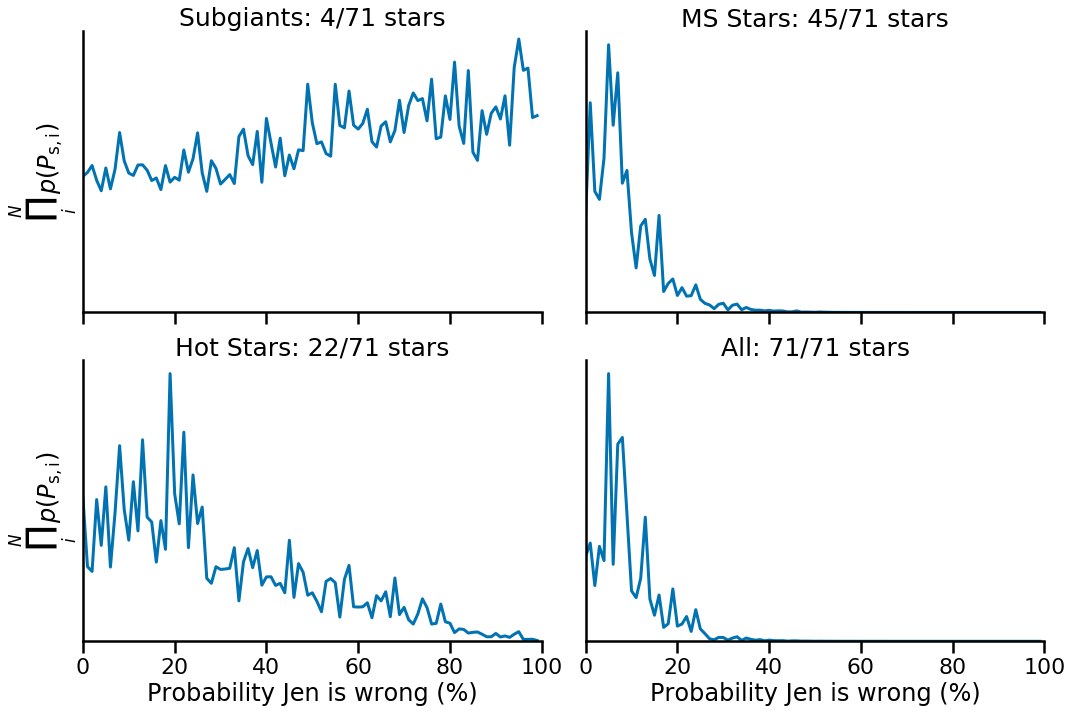

In [15]:
fig, ax = plt.subplots(2, 2, sharex=True,  figsize=(15,10))
ax = ax.flatten()
ax[0].plot(bins[:-1], np.prod(hists_sel_cov[sg], axis=0))
ax[0].set_title(fr'Subgiants: {len(hists_sel_cov[sg])}/{len(c2[sel])} stars', fontsize=25)
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)

ax[1].plot(bins[:-1], np.prod(hists_sel_cov[ms], axis=0))
ax[1].set_title(fr'MS Stars: {len(hists_sel_cov[ms])}/{len(c2[sel])} stars', fontsize=25)
ax[1].get_yaxis().set_ticks([])
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0)

ax[2].plot(bins[:-1], np.prod(hists_sel_cov[h], axis=0))
ax[2].set_title(fr'Hot Stars: {len(hists_sel_cov[h])}/{len(c2[sel])} stars', fontsize=25)
ax[2].get_yaxis().set_ticks([])
ax[2].set_xlim(0, 1)
ax[2].set_ylim(0)

ax[3].plot(bins[:-1], np.prod(hists_sel_cov, axis=0))
ax[3].set_title(fr'All: {len(hists_sel_cov)}/{len(c2[sel])} stars', fontsize=25)
ax[3].get_yaxis().set_ticks([])
ax[3].set_xlim(0, 1)
ax[3].set_ylim(0)

ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s, i}})$')
ax[2].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s, i}})$')
ax[2].set_xlabel(r'Probability Jen is wrong (%)')
ax[3].set_xlabel(r'Probability Jen is wrong (%)')
ax[2].set_xticklabels(['0', '20','40','60','80','100'])

sns.despine()
fig.tight_layout()
plt.show()

In [44]:
p0 = np.prod(hists_sel_cov[:,:50],axis=0)
p1 = np.prod(hists_sel_cov[:,50:],axis=0)

In [53]:
print(np.sum(p0))
print(np.sum(p1))
print(f'{100*np.sum(p0)/(np.sum(p0) + np.sum(p1))}%')

12112.471961043431
3.8333825033986
99.96836178690857%


In [18]:
def mnras_size(fig_width_pt, square=False):
    inches_per_pt = 1.0/72.00              # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0     # Most aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt # Figure width in inches
    if square:
        fig_height = fig_width
    else:
        fig_height = fig_width*golden_mean
    return [fig_width,fig_height]

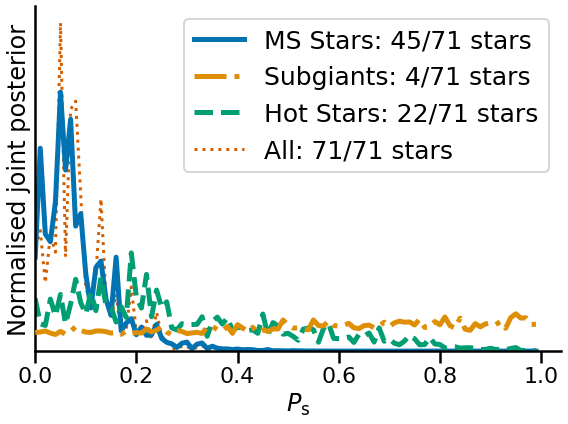

In [19]:
fig, ax = plt.subplots(figsize=(8,6))



y = np.prod(hists_sel_cov[ms], axis=0)
ax.plot(bins[:-1], y / np.mean(y), lw=5, zorder=1,
        label=fr'MS Stars: {len(hists_sel_cov[ms])}/{len(c2[sel])} stars')

y = np.prod(hists_sel_cov[sg], axis=0)
ax.plot(bins[:-1], y / np.mean(y), ls='-.', zorder=3, lw=5,
        label=fr'Subgiants: {len(hists_sel_cov[sg])}/{len(c2[sel])} stars')

y =  np.prod(hists_sel_cov[h], axis=0)
ax.plot(bins[:-1], y / np.mean(y), ls='--', zorder=2, lw=5,
        label=fr'Hot Stars: {len(hists_sel_cov[h])}/{len(c2[sel])} stars')
                       
y = np.prod(hists_sel_cov, axis=0)
ax.plot(bins[:-1], y / np.mean(y), ls=':', zorder=0,
        label=fr'All: {len(hists_sel_cov)}/{len(c2[sel])} stars')


ax.set_ylabel(r'Normalised joint posterior')
ax.set_xlabel(r'$P_{\rm s}$')
ax.set_yticks([])
# ax.set_yscale('log')
ax.set_ylim(0)
ax.set_xlim(0)
ax.legend(loc='upper right', fontsize=25)

sns.despine()
fig.tight_layout()

plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/type_comparison.png', bbox_inches='tight', dpi=300)
plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/type_comparison.pdf', bbox_inches='tight', rasterized=True)
plt.show()

Some final notes:
- Even when being extra careful with our sample, we are in favour of weakened magnetic braking.
- Subgiants hold little diagnostic power (as expected).
- Stars above the kraft break seem to favour weakened magnetic braking. **Is this due to the models having different temperature ranges**?
- Main sequence stars hold the majority of the diagnostic power, and fall strongly in favour of weakened magnetic braking.

In [20]:
fsel = ati['KIC'].isin(c2[sel]['KIC'])
f_post_pa = np.array(post_pa)[fsel]

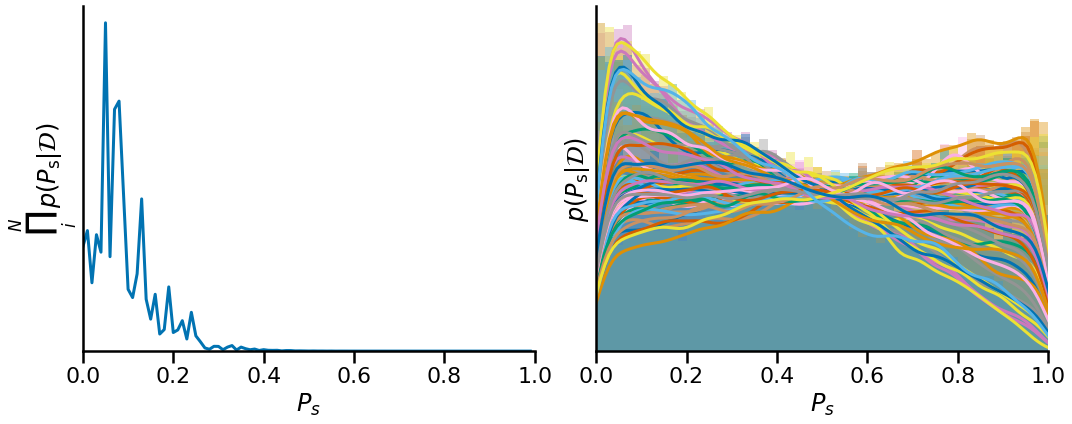

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(bins[:-1], np.prod(hists_sel_cov, axis=0))
# ax[0].set_xlabel('Probability vS+16 is wrong')
ax[0].set_xlabel(r'$P_s$')
# ax[0].set_xlabel(r'$P_{\rm s}$')
ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s}} | \mathcal{D})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
for n in f_post_pa:
    sns.distplot(n, ax=ax[1])
ax[1].set_ylabel(r'$p(P_{\rm{s}} | \mathcal{D})$')
ax[1].set_xlabel(r'$P_s$')
ax[1].set_xlim(0, 1)
# ax[1].set_ylim(0)
ax[1].get_yaxis().set_ticks([])
sns.despine()

# fig.suptitle(fr'Using {len(hists_sel_cov)}/95 stars', fontsize=25)
fig.tight_layout()
plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/modelresults.pdf', bbox_inches='tight',rasterized=True)
plt.show()

## Check the posterior excluding stars with mass uncertainties below 0.02 Msol

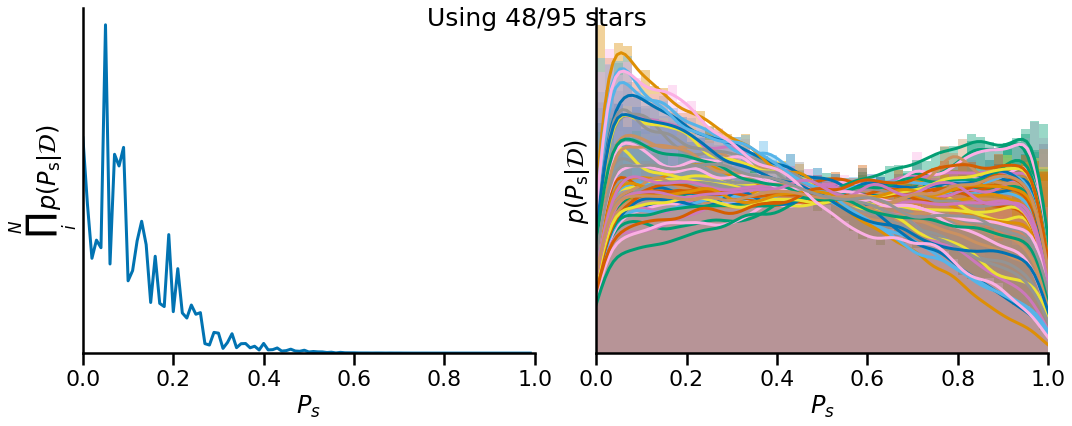

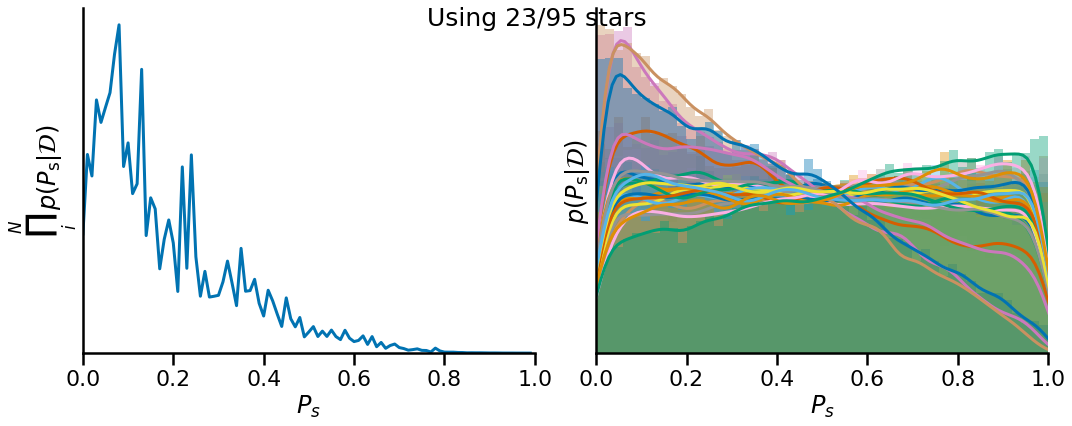

In [22]:
fin = ati[fsel]
sel = (fin.upmodmass > 0.02) & (fin.lomodmass > 0.02)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(bins[:-1], np.prod(hists_sel_cov[sel], axis=0))
ax[0].set_xlabel(r'$P_s$')
ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s}} | \mathcal{D})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
for n in f_post_pa[sel]:
    sns.distplot(n, ax=ax[1])
ax[1].set_ylabel(r'$p(P_{\rm{s}} | \mathcal{D})$')
ax[1].set_xlabel(r'$P_s$')
ax[1].set_xlim(0, 1)
ax[1].get_yaxis().set_ticks([])
sns.despine()

fig.suptitle(fr'Using {len(hists_sel_cov[sel])}/95 stars', fontsize=25)
fig.tight_layout()
plt.show()
fin = ati[fsel]
sel = (fin.upmodmass > 0.02) & (fin.lomodmass > 0.02)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(bins[:-1], np.prod(hists_sel_cov[~sel], axis=0))
ax[0].set_xlabel(r'$P_s$')
ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s}} | \mathcal{D})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
for n in f_post_pa[~sel]:
    sns.distplot(n, ax=ax[1])
ax[1].set_ylabel(r'$p(P_{\rm{s}} | \mathcal{D})$')
ax[1].set_xlabel(r'$P_s$')
ax[1].set_xlim(0, 1)
ax[1].get_yaxis().set_ticks([])
sns.despine()

fig.suptitle(fr'Using {len(hists_sel_cov[~sel])}/95 stars', fontsize=25)
fig.tight_layout()
plt.show()

## I want to exclude stars that were in the JvS+19 sample

In [23]:
fin = ati[fsel]
mss = fin[fin.hrclass == 'MS']
f_post_pa = np.array(post_pa)[fsel]
ms_post_pa = f_post_pa[fin.hrclass == 'MS']
ms_hists = hists_sel_cov[fin.hrclass == 'MS']

In [24]:
excl = [12069424,
12069449,
3427720,
3656476,
5184732,
6116048,
6196457,
6521045,
7680114,
7871531,
8006161,
8349582,
9098294,
9139151,
9955598,
10454113,
10586004,
10644253,
10963065,
11244118,
11401755]

In [25]:
sel = ~mss.KIC.isin(excl)

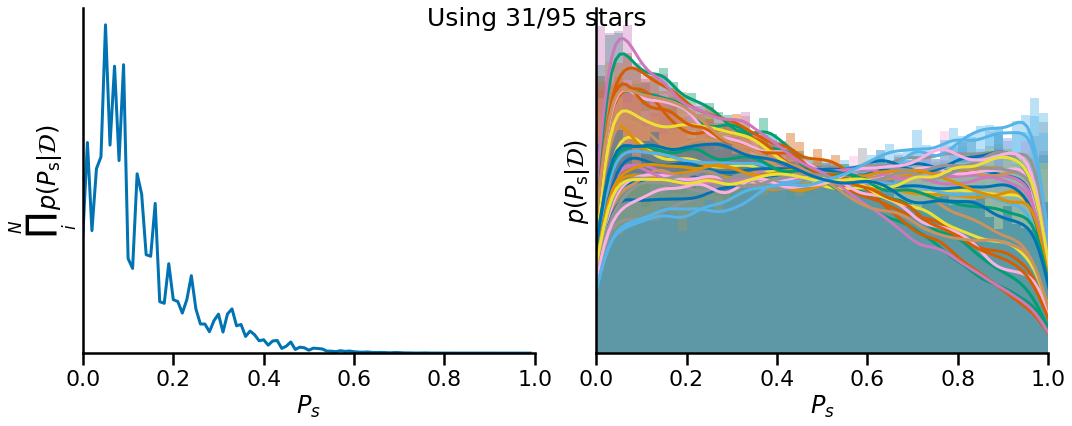

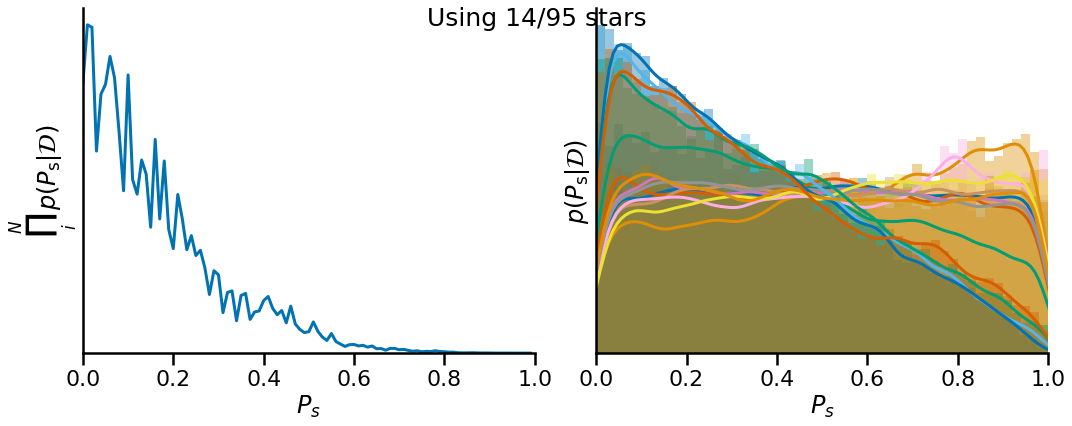

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(bins[:-1], np.prod(ms_hists[sel], axis=0))
ax[0].set_xlabel(r'$P_s$')
ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s}} | \mathcal{D})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
for n in ms_post_pa[sel]:
    sns.distplot(n, ax=ax[1])
ax[1].set_ylabel(r'$p(P_{\rm{s}} | \mathcal{D})$')
ax[1].set_xlabel(r'$P_s$')
ax[1].set_xlim(0, 1)
ax[1].get_yaxis().set_ticks([])
sns.despine()

fig.suptitle(fr'Using {len(ms_hists[sel])}/95 stars', fontsize=25)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(bins[:-1], np.prod(ms_hists[~sel], axis=0))
ax[0].set_xlabel(r'$P_s$')
ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s}} | \mathcal{D})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
for n in ms_post_pa[~sel]:
    sns.distplot(n, ax=ax[1])
ax[1].set_ylabel(r'$p(P_{\rm{s}} | \mathcal{D})$')
ax[1].set_xlabel(r'$P_s$')
ax[1].set_xlim(0, 1)
ax[1].get_yaxis().set_ticks([])
sns.despine()

fig.suptitle(fr'Using {len(ms_hists[~sel])}/95 stars', fontsize=25)
fig.tight_layout()
plt.show()

## Check against Lorenzo-Oliveira stars

In [27]:
fin = ati[fsel]
print(len(fin))

71


In [28]:
excl = [6541920,
        10130039,
       12404954,
       7202957]
sel = fin.KIC.isin(excl)

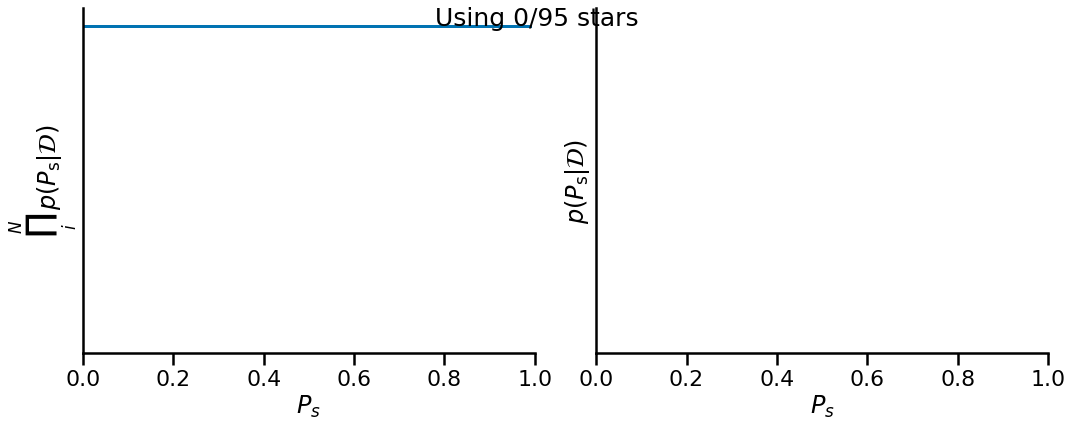

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15,6))
ax[0].plot(bins[:-1], np.prod(hists_sel_cov[sel], axis=0))
ax[0].set_xlabel(r'$P_s$')
ax[0].set_ylabel(r'$\prod_i^N\ p(P_{\rm{s}} | \mathcal{D})$')
ax[0].get_yaxis().set_ticks([])
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0)
for n in f_post_pa[sel]:
    sns.distplot(n, ax=ax[1])
ax[1].set_ylabel(r'$p(P_{\rm{s}} | \mathcal{D})$')
ax[1].set_xlabel(r'$P_s$')
ax[1].set_xlim(0, 1)
ax[1].get_yaxis().set_ticks([])
sns.despine()

fig.suptitle(fr'Using {len(hists_sel_cov[sel])}/95 stars', fontsize=25)
fig.tight_layout()
plt.show()

## Finally, let's plot the stars in this final example

In [30]:
standard = pd.read_hdf('../data/jvs_models/standard_population.h5', key='sample', mode='r')
standard.rename(columns={'period':'P',
                         'age':'Age','mass':'M'}, inplace=True)
standard.head(1)

,M,Teff,logg,Age,log(L/Lsun),kepmag,P,[Fe/H],sdss_g,sdss_r,sdss_i,sdss_z,2mass_j,2mass_h,2mass_k,distmod,av
0,0.90424,5674.121798,4.54636,2.34408,-0.183266,13.179899,16.514088,-0.25,13.608602,13.11637,12.989363,12.9559,12.057497,11.71793,11.673961,8.0,0.023


In [31]:
rocrit = pd.read_hdf('../data/jvs_models/rocrit_population.h5', key='sample', mode='r')
rocrit.rename(columns={'period':'P',
                         'age':'Age','mass':'M'}, inplace=True)
rocrit.head(1)

,M,Teff,logg,Age,log(L/Lsun),kepmag,P,[Fe/H],sdss_g,sdss_r,sdss_i,sdss_z,2mass_j,2mass_h,2mass_k,distmod,av
0,1.61144,5058.112357,3.440028,1.877246,0.974361,11.350579,45.489845,-0.11,11.991957,11.279396,11.073495,10.975381,9.958406,9.495029,9.427129,9.0,0.028


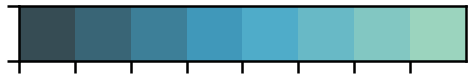

In [32]:
from matplotlib.colors import ListedColormap
snsmap = sns.color_palette('GnBu_d',8)
cmap = ListedColormap(snsmap.as_hex())
sns.palplot(snsmap)

In [33]:
sg = ati['hrclass'] == 'SG'
ms = ati['hrclass'] == 'MS'
h = ati['hrclass'] == 'H'

### All stars & models

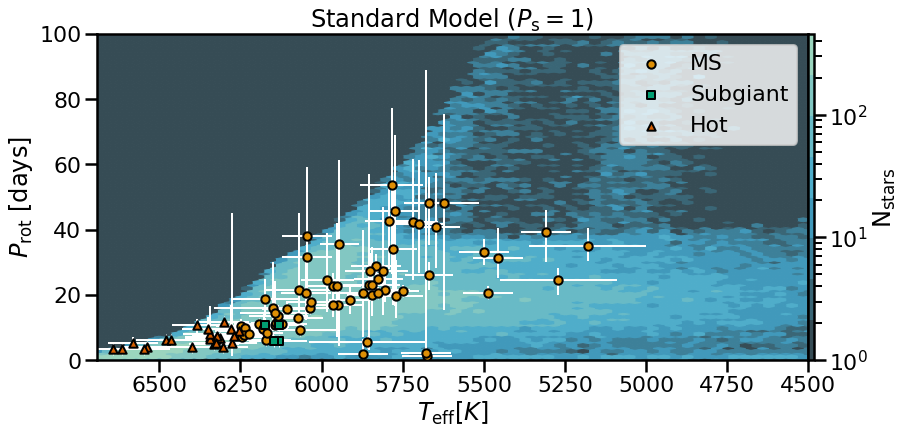

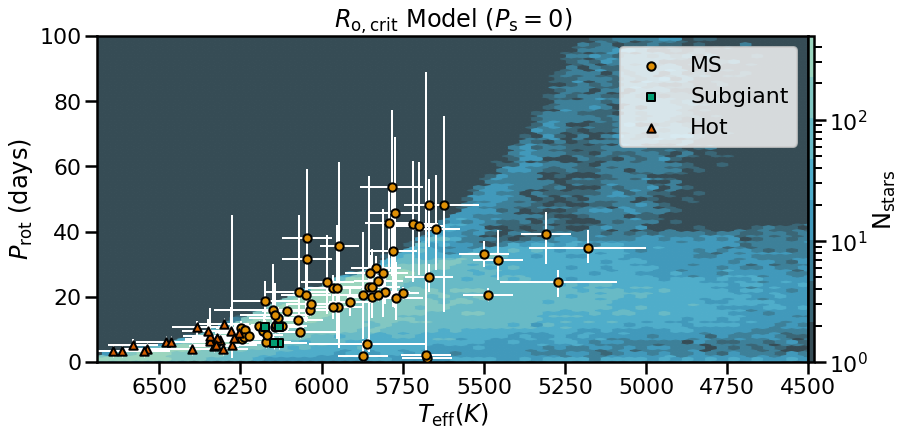

In [34]:
fig = plt.figure(figsize=(15,6))
ax = plt.gca()
c = ax.hexbin(standard.Teff, standard.P, cmap=cmap, bins='log')
ax.invert_xaxis()
ax.scatter(np.nan, np.nan)
ax.scatter(ati.Teff[ms], ati.P[ms], marker='o', s=70,zorder=3, ec='k', lw='2', label='MS')
# ax.scatter(ati.Teff[ms], ati.P[ms], c='k', marker='o', s=100,zorder=2)

ax.scatter(ati.Teff[sg], ati.P[sg], marker=',', s=70,zorder=3, ec='k', lw='2', label='Subgiant')
# ax.scatter(ati.Teff[sg], ati.P[sg], c='k', marker=',', s=100,zorder=2)

ax.scatter(ati.Teff[h], ati.P[h], marker='^', s=70,zorder=3, ec='k', lw='2', label='Hot')
# ax.scatter(ati.Teff[h], ati.P[h], c='k', marker='^', s=100,zorder=2)

ax.errorbar(ati.Teff, ati.P, c='w', lw=2, xerr=ati.eTeff, yerr=[ati.l_P, ati.u_P], fmt='|', zorder=1)
ax.set_ylim(0, 100)
ax.set_xlim(ati.Teff.max()+50, 4500)
ax.set_ylabel(r'$P_{\rm rot}$ [days]')
ax.set_xlabel(r'$T_{\rm eff} [K]$')
ax.set_title(r'Standard Model ($P_{\rm s} = 1$) ')
ax.legend(loc='upper right')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)
plt.show()

fig = plt.figure(figsize=(15,6))
ax = plt.gca()
c = ax.hexbin(rocrit.Teff, rocrit.P, cmap=cmap, bins='log')
ax.invert_xaxis()
ax.scatter(np.nan, np.nan)
ax.scatter(ati.Teff[ms], ati.P[ms], marker='o', s=70,zorder=3, ec='k', lw='2', label='MS')
ax.scatter(ati.Teff[sg], ati.P[sg], marker=',', s=70,zorder=3, ec='k', lw='2', label='Subgiant')
ax.scatter(ati.Teff[h], ati.P[h], marker='^', s=70,zorder=3, ec='k', lw='2', label='Hot')

ax.errorbar(ati.Teff, ati.P, c='w', lw=2, xerr=ati.eTeff, yerr=[ati.l_P, ati.u_P], fmt='|', zorder=1)
ax.set_ylim(0, 100)
ax.set_xlim(ati.Teff.max()+50, 4500)
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
ax.set_title(r'$R_{\rm o,crit}$ Model ($P_{\rm s} = 0$)')
ax.legend(loc='upper right')
fig.colorbar(c,label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)
plt.show()

### Flagging stars for various points of interest:

In [35]:
fin = ati[fsel]
Ps = np.median(f_post_pa, axis=1)
exc = ati.loc[~ati['KIC'].isin(fin.KIC)]
feh = fin.loc[np.abs(fin.feh.values) > 0.4]
excfeh = exc.loc[np.abs(exc.feh.values) > 0.4]

In [36]:
ms = (fin.hrclass == 'MS').values
h = (fin.hrclass == 'H').values
sg = (fin.hrclass == 'SG').values

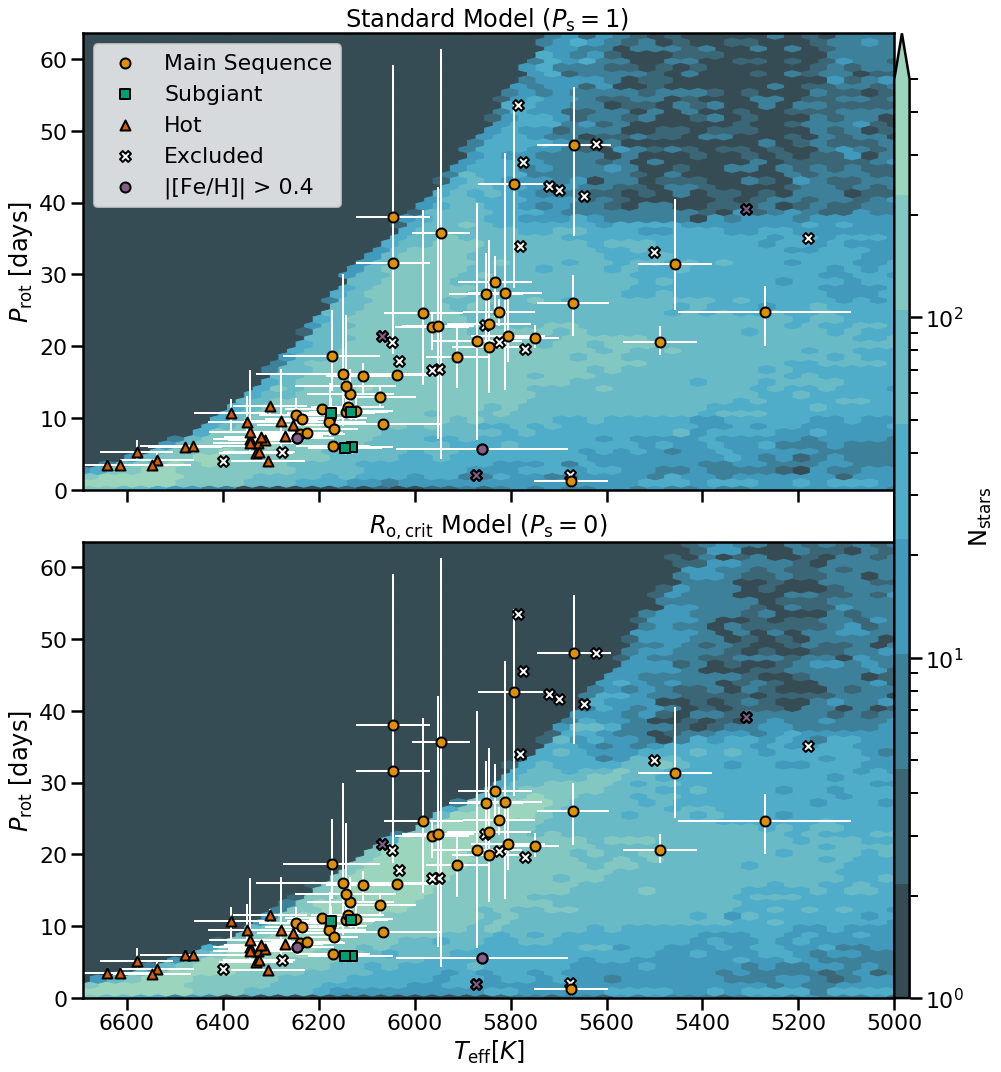

In [37]:
fig, axes = plt.subplots(2,1, figsize=(15,15), sharex=True)
# ax = plt.gca()
ax = axes[0]
c = ax.hexbin(standard.Teff, standard.P, cmap=cmap, bins='log', vmin=1, vmax=500)
ax.invert_xaxis()
ax.scatter(np.nan, np.nan)
ax.scatter(fin.Teff[ms], fin.P[ms], marker='o', s=100,zorder=3, ec='k', lw='2', label='Main Sequence')
ax.scatter(fin.Teff[sg], fin.P[sg], marker=',', s=100,zorder=3, ec='k', lw='2', label='Subgiant')
ax.scatter(fin.Teff[h], fin.P[h], marker='^', s=100,zorder=3, ec='k', lw='2', label='Hot')

# Excluded
ax.scatter(exc.Teff, exc.P, marker='X', s=120,zorder=2, ec='k', c='w', lw=2, label='Excluded')
# FeH
ax.scatter(excfeh.Teff, excfeh.P, marker='X', s=120,zorder=5, ec='k', 
           c=sns.xkcd_rgb["dusty purple"], lw=2)
ax.scatter(feh.Teff, feh.P, marker='o', s=100,zorder=5, ec='k', 
           c=sns.xkcd_rgb["dusty purple"], lw=2, label='|[Fe/H]| > 0.4')
ax.errorbar(fin.Teff, fin.P, c='w', lw=2, xerr=fin.eTeff, yerr=[fin.l_P, fin.u_P], fmt='|', zorder=1)
ax.set_ylim(0, ati.P.max() + 10)
ax.set_xlim(ati.Teff.max()+50, 5000)
ax.set_ylabel(r'$P_{\rm rot}$ [days]')
# ax.set_xlabel(r'$T_{\rm eff} (K)$')
ax.set_title(r'Standard Model ($P_{\rm s} = 1$) ')
ax.legend(loc='upper left')

ax = axes[1]
c = ax.hexbin(rocrit.Teff, rocrit.P, cmap=cmap, bins='log', vmin=1, vmax=500)
ax.invert_xaxis()
ax.scatter(np.nan, np.nan)
ax.scatter(fin.Teff[ms], fin.P[ms], marker='o', s=100,zorder=3, ec='k', lw='2', label='Main Sequence')
ax.scatter(fin.Teff[sg], fin.P[sg], marker=',', s=100,zorder=3, ec='k', lw='2', label='Subgiant')
ax.scatter(fin.Teff[h], fin.P[h], marker='^', s=100,zorder=3, ec='k', lw='2', label='Hot')

ax.scatter(exc.Teff, exc.P, marker='X', s=120,zorder=2, ec='k', c='w', lw=2, label='Excluded')
ax.scatter(excfeh.Teff, excfeh.P, marker='X', s=120,zorder=5, ec='k', 
           c=sns.xkcd_rgb["dusty purple"], lw=2)
ax.scatter(feh.Teff, feh.P, marker='o', s=100,zorder=5, ec='k', 
           c=sns.xkcd_rgb["dusty purple"], lw=2, label='|[Fe/H]| > 0.4')

ax.errorbar(fin.Teff, fin.P, c='w', lw=2, xerr=fin.eTeff, yerr=[fin.l_P, fin.u_P], fmt='|', zorder=1)
ax.set_ylim(0, ati.P.max() + 10)
ax.set_xlim(ati.Teff.max()+50, 5000)
ax.set_ylabel(r'$P_{\rm rot}$ [days]')
ax.set_xlabel(r'$T_{\rm eff} [K]$')
ax.set_title(r'$R_{\rm o,crit}$ Model ($P_{\rm s} = 0$)')
# ax.legend(loc='upper left')

fig.tight_layout()
fig.colorbar(c, ax=axes.ravel(),label=r'$\rm{N_{\rm stars}}$', pad=0, aspect=60, extend='max')
plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/fullsample.png', bbox_inches='tight', dpi=300)
plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/fullsample.pdf', bbox_inches='tight', rasterized=True)
plt.show()

### Let's plot the posterior distributions on $P_s$ for stars outside the [Fe/H] range

In [38]:
feh = ati[np.abs(ati.feh) > 0.4]
feh_pa = np.array(post_pa)[np.abs(ati.feh) > 0.4]
mass = ati[ati.modmass >= 1.3]
mass_pa = np.array(post_pa)[ati.modmass >= 1.3]

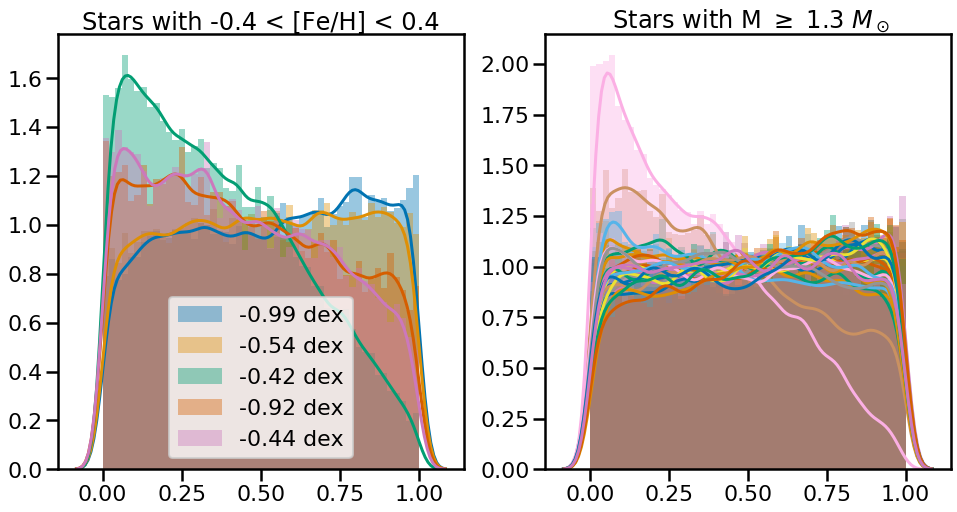

In [39]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(16,8))
for idx, pa in enumerate(feh_pa):
    sns.distplot(pa, label=f'{feh.feh.values[idx]} dex', ax=ax)
for idx, pa in enumerate(mass_pa):
    sns.distplot(pa, ax=ax2)    
ax.legend(loc='lower center')
ax.set_title(r'Stars with -0.4 < [Fe/H] < 0.4')
ax2.set_title(r' Stars with M $\geq$ 1.3 $M_\odot$')
plt.show()

And again, but only for included stars

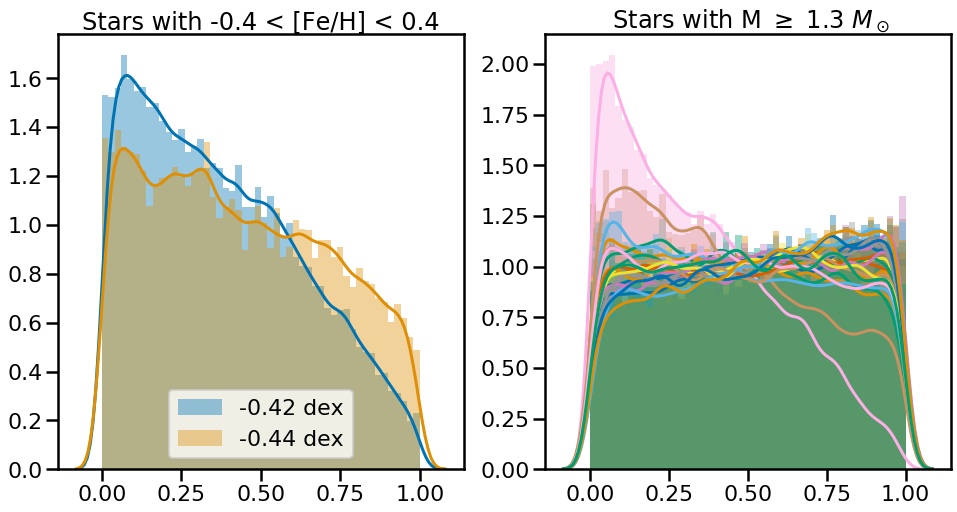

In [40]:
feh = fin[np.abs(fin.feh) > 0.4]
feh_pa = np.array(f_post_pa)[np.abs(fin.feh) > 0.4]
mass = fin[fin.modmass >= 1.3]
mass_pa = np.array(f_post_pa)[fin.modmass >= 1.3]

fig, (ax, ax2) = plt.subplots(1,2, figsize=(16,8))
for idx, pa in enumerate(feh_pa):
    sns.distplot(pa, label=f'{feh.feh.values[idx]} dex', ax=ax)
for idx, pa in enumerate(mass_pa):
    sns.distplot(pa, ax=ax2)    
ax.legend(loc='lower center')
ax.set_title(r'Stars with -0.4 < [Fe/H] < 0.4')
ax2.set_title(r' Stars with M $\geq$ 1.3 $M_\odot$')
plt.show()

Doing a check on stars with uncertainty below the 0.02 mass binwidth

### Let's look at the median values for $P_s$ for our stars of interest

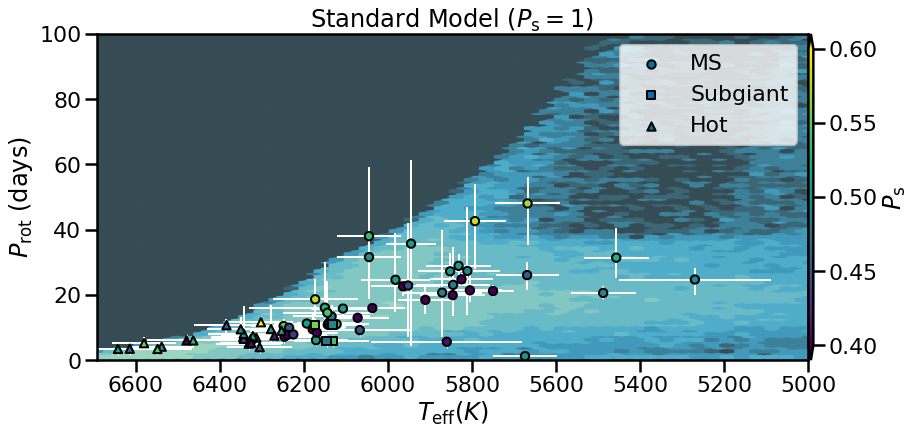

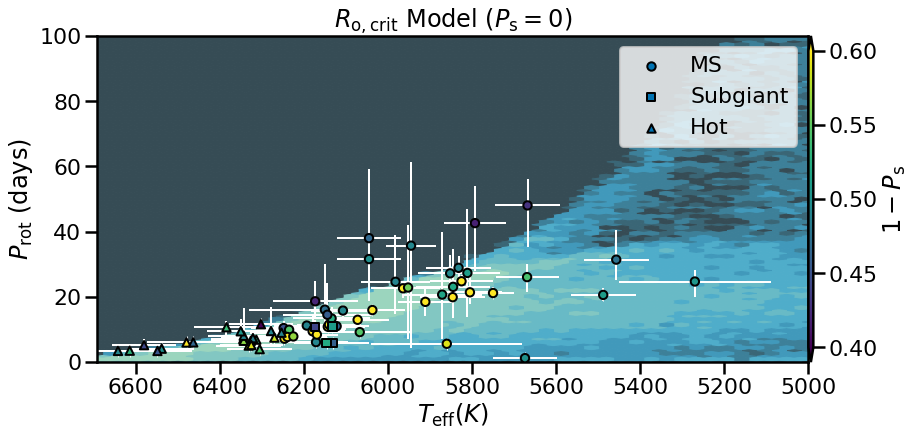

In [41]:
fig = plt.figure(figsize=(15,6))
ax = plt.gca()
c = ax.hexbin(standard.Teff, standard.P, cmap=cmap, bins='log')
ax.invert_xaxis()
c= ax.scatter(fin.Teff[ms], fin.P[ms], marker='o', s=70, zorder=3, ec='k', c=Ps[ms], lw=2, label='MS',
          vmin=0.4 , vmax=0.6)
ax.scatter(fin.Teff[sg], fin.P[sg], marker=',', s=70,zorder=3, ec='k', c=Ps[sg],  lw=2, label='Subgiant',
          vmin=0.4 , vmax=0.6)
ax.scatter(fin.Teff[h], fin.P[h], marker='^', s=70,zorder=3, ec='k', c=Ps[h],  lw=2, label='Hot',
          vmin=0.4 , vmax=0.6)

ax.errorbar(fin.Teff, fin.P, c='w', lw=2, xerr=fin.eTeff, yerr=[fin.l_P, fin.u_P], fmt='|', zorder=1)
ax.set_ylim(0, 100)
ax.set_xlim(fin.Teff.max()+50, 5000)
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
ax.set_title(r'Standard Model ($P_{\rm s} = 1$) ')
ax.legend(loc='upper right')
# fig.colorbar(c, label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60)
fig.colorbar(c, label=r'$P_{\rm s}$', pad=0,aspect=60, extend='both')
plt.show()

fig = plt.figure(figsize=(15,6))
ax = plt.gca()
c = ax.hexbin(rocrit.Teff, rocrit.P, cmap=cmap, bins='log')
ax.invert_xaxis()
ax.scatter(np.nan, np.nan)
c = ax.scatter(fin.Teff[ms], fin.P[ms], marker='o', s=70,zorder=3, ec='k',  c=(1.-Ps[ms]), lw=2, 
               vmin = 0.4, vmax=0.6, label='MS')
ax.scatter(fin.Teff[sg], fin.P[sg], marker=',', s=70,zorder=3, ec='k',  c=(1.-Ps[sg]), lw=2, 
           vmin = 0.4, vmax=0.6, label='Subgiant')
ax.scatter(fin.Teff[h], fin.P[h], marker='^', s=70,zorder=3, ec='k',  c=(1.-Ps[h]), lw=2, 
           vmin = 0.4, vmax=0.6, label='Hot')

ax.errorbar(fin.Teff, fin.P, c='w', lw=2, xerr=fin.eTeff, yerr=[fin.l_P, fin.u_P], fmt='|', zorder=1)
ax.set_ylim(0, 100)
ax.set_xlim(fin.Teff.max()+50, 5000)
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$T_{\rm eff} (K)$')
ax.set_title(r'$R_{\rm o,crit}$ Model ($P_{\rm s} = 0$)')
ax.legend(loc='upper right')
fig.colorbar(c, label=r'$1 - P_{\rm s}$', pad=0,aspect=60, extend='both')
plt.show()

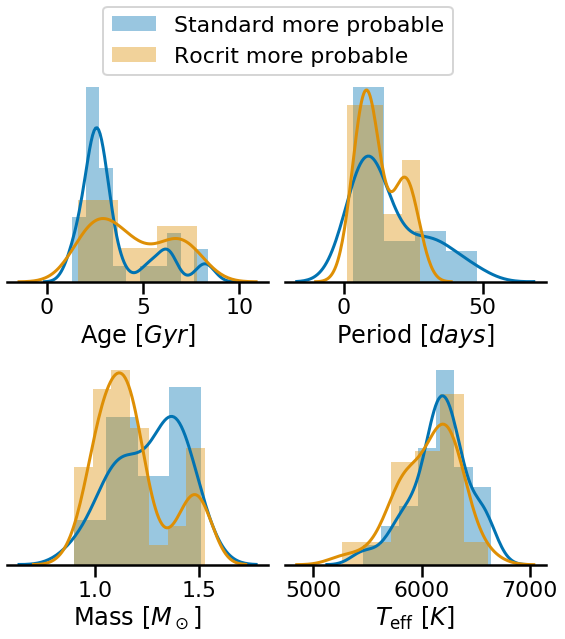

In [42]:
fig, axes = plt.subplots(2,2, figsize=(8,8))
ax = axes.ravel()
sns.distplot(fin[Ps > 0.5].age, ax=ax[0], label='Standard more probable')
sns.distplot(fin[Ps < 0.5].age, ax=ax[0], label='Rocrit more probable')
ax[0].set_xlabel(r'Age [$Gyr$]')

sns.distplot(fin[Ps > 0.5].P, ax=ax[1])
sns.distplot(fin[Ps < 0.5].P, ax=ax[1])
ax[1].set_xlabel(r'Period [$days$]')

sns.distplot(fin[Ps > 0.5].modmass, ax=ax[2])
sns.distplot(fin[Ps < 0.5].modmass, ax=ax[2])
ax[2].set_xlabel(r'Mass [$M_\odot$]')

sns.distplot(fin[Ps > 0.5].Teff, ax=ax[3])
sns.distplot(fin[Ps < 0.5].Teff, ax=ax[3])
ax[3].set_xlabel(r'$T_{\rm eff}$ [$K$]')


sns.despine()
for a in ax:
    a.spines['left'].set_visible(False)
    a.set_yticks([])
fig.tight_layout()
ax[0].legend(bbox_to_anchor=(0.75,0.4,1,1))
plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/sample_posterior_comp.png', dpi=300)
plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/sample_posterior_comp.pdf', rasterized=True)
plt.show()

In [43]:
sys.exit()

NameError: name 'sys' is not defined

And in other parameter spaces:

In [ ]:
sg = fin['hrclass'] == 'SG'
ms = fin['hrclass'] == 'MS'
h = fin['hrclass'] == 'H'

In [ ]:
## Age v P
fig = plt.figure(figsize=(15,6))
ax = plt.gca()
c = ax.hexbin(rocrit.Age, rocrit.P, cmap=cmap, bins='log')
c = ax.scatter(fin.age[ms], fin.P[ms], marker='o', s=70,zorder=3, ec='k',  c=(1.-Ps[ms]), lw=2, 
               vmin = 0.4, vmax=0.6, label='MS')
ax.scatter(fin.age[sg], fin.P[sg], marker=',', s=70,zorder=3, ec='k',  c=(1.-Ps[sg]), lw=2, 
           vmin = 0.4, vmax=0.6, label='Subgiant')
ax.scatter(fin.age[h], fin.P[h], marker='^', s=70,zorder=3, ec='k',  c=(1.-Ps[h]), lw=2, 
           vmin = 0.4, vmax=0.6, label='Hot')

ax.errorbar(fin.age, fin.P, c='w', lw=2, xerr=[fin.loage, fin.upage], yerr=[fin.l_P, fin.u_P], fmt='|', zorder=1)
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$\tau\ [\rm{Gyr}]$')
ax.set_title(r'$R_{\rm o,crit}$ Model ($P_{\rm s} = 0$)')
ax.legend(loc='upper left')

ax.set_xlim(rocrit.Age.min(), rocrit.Age.max())
ax.set_ylim(0, 60)
fig.colorbar(c, label=r'$1 - P_{\rm s}$', pad=0,aspect=60, extend='both')
plt.show()

## Mass v P
fig = plt.figure(figsize=(15,6))
ax = plt.gca()
c = ax.hexbin(rocrit.M, rocrit.P, cmap=cmap, bins='log')
c = ax.scatter(fin.modmass[ms], fin.P[ms], marker='o', s=70,zorder=3, ec='k',  c=(1.-Ps[ms]), lw=2, 
               vmin = 0.4, vmax=0.6, label='MS')
ax.scatter(fin.modmass[sg], fin.P[sg], marker=',', s=70,zorder=3, ec='k',  c=(1.-Ps[sg]), lw=2, 
           vmin = 0.4, vmax=0.6, label='Subgiant')
ax.scatter(fin.modmass[h], fin.P[h], marker='^', s=70,zorder=3, ec='k',  c=(1.-Ps[h]), lw=2, 
           vmin = 0.4, vmax=0.6, label='Hot')

ax.errorbar(fin.modmass, fin.P, c='w', lw=2,
            xerr=[fin.lomodmass, fin.upmodmass], yerr=[fin.l_P, fin.u_P], fmt='|', zorder=1)
ax.set_ylabel(r'$P_{\rm rot}$ (days)')
ax.set_xlabel(r'$M\ [M_\odot]$')
ax.set_title(r'$R_{\rm o,crit}$ Model ($P_{\rm s} = 0$)')
ax.legend(loc='upper left')

ax.set_xlim(1.6, 0.8)
ax.set_ylim(0, 60)
fig.colorbar(c, label=r'$1 - P_{\rm s}$', pad=0,aspect=60, extend='both')
plt.show()